In [ ]:
# default_exp data.load 

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [ ]:
# hide
from nbdev.showdoc import *

# Data Load

> Using the fastai2 `Datasets` to make an time series dataset.

For now all is univerable but in the future I would also like to add multiplevariable. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [ ]:
# export
import numpy as np
import pandas as pd

# Dataloader

In [ ]:
# export
@delegates()
class TSDataLoader(TfmdDL):
    def __init__(self, dataset, horizon, lookback=72, step=1, max_std=200, **kwargs):
        self.horizon, self.lookback, self.step, self.max_std = horizon, lookback, step, max_std
        self.dataset = [o.float() for o in L(dataset).map(tensor)]
        n = self.make_ids()
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.skipped= []
        
    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        res = super().new(dataset, cls, horizon=self.horizon, lookback=self.lookback, step=self.step , **kwargs)       
        res.make_ids() 
        return res
    
    def make_ids(self):
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in enumerate(self.dataset):
            if isinstance(ts,tuple):
                ts = ts[0] # no idea why they become tuples
            num_examples = (ts.shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts.shape[-1] < self.horizon:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts.shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
    def shuffle_fn(self, idxs):
#         self.dataset.shuffle()
        return idxs

    def get_id(self, idx):
        # Get time series
        ts_id, lookback_id = self._ids[idx]
        ts = self.dataset[ts_id]
        if isinstance(ts,tuple):
            ts = ts[0] # no idea why they become tuples
        # Prepare input and target. Zero pad if necessary.
        if ts.shape[-1] < self.lookback + self.horizon:
            # If the time series is too short, we zero pad
            x = ts[:, :-self.horizon]
            x = np.pad(
                x,
                pad_width=((0, 0), (self.lookback - x.shape[-1], 0)),
                mode='constant',
                constant_values=0
            )
            y = ts[:,-self.lookback + self.horizon:]
            y = np.pad(
                y,
                pad_width=((0, 0), (self.lookback + self.horizon - y.shape[-1], 0)),
                mode='constant',
                constant_values=0
            )
            assert y.shape == (1,self.lookback+self.horizon), f"{y.shape}\t,{idx}, , 'tsshape':{ts.shape},'ts_id':{ts_id}"
        else:
            x = ts[:,lookback_id:lookback_id + self.lookback]
            y = ts[:,lookback_id:lookback_id + self.lookback + self.horizon]
        return x, y

    def create_item(self, idx):
        if idx>=self.n: 
            raise IndexError            
        x, y  = self.get_id(idx)
        if (y/x.std()).std()>self.max_std:
            if idx not in self.skipped:
#                 print(f"idx: {idx};y.std to high: {(y/x.std()).std()} > {self.max_std}")
                self.skipped.append(idx)
            raise SkipItemException()
            
        return TSTensorSeq(x),TSTensorSeqy(y)

In [ ]:
# hide
horizon,lookback = 2,10
ints = L(np.arange(10)[None,:])
dl = TSDataLoader(ints, horizon = horizon, lookback = lookback)

for o in dl:
    pass
horizon,lookback = 8,2
ints = L(np.arange(10)[None,:])
dl = TSDataLoader(ints, horizon = horizon, lookback = lookback)

for o in dl:
    pass

Need to pad 1/1 time series due to length.


In [ ]:
# hide
horizon,lookback = 2,10
ints = L(np.concatenate([np.ones(10),np.array([1e10])])[None,:])
print(ints)
dl = TSDataLoader(ints, horizon = horizon, lookback = lookback)
list(o for o in dl)

(#1) [array([[1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00,
        1.e+00, 1.e+00, 1.e+10]])]
Need to pad 1/1 time series due to length.
idx: 0;y.std to high: 9212847104.0 > 200


[]

In [ ]:
# hide
horizon,lookback = 8,2
ints = L(np.arange(10)[None,:])
dl = TSDataLoader(ints, horizon = horizon, lookback = lookback)

for o in dl:
    pass

In [ ]:
# hide
horizon,lookback = 2,5
ints = L(np.arange(7)[None,:],np.arange(7,15)[None,:],np.arange(15,25)[None,:]).map(tensor)
dl = TSDataLoader(ints, horizon = horizon, lookback = lookback, bs=2)
test_eq(dl.n, len(dl._ids))
test_eq(dl.n, 7)
test_eq(len(dl),4)    
test_eq(dl.one_batch()[0].dtype,torch.float)
for o in dl:pass

In [ ]:
# hide
ints = L(np.arange(10)[None,:],np.arange(20,30)[None,:],np.arange(40,50)[None,:])
dl = TSDataLoader(ints, horizon = horizon, lookback = lookback, bs=6, shuffle=False)

test_eq(dl.n, len(dl._ids))
test_eq(dl.n, 12)
test_eq(len(dl), 2)

dl_new = dl.new()
test_eq(dl_new.lookback,dl.lookback)

test_eq(dl_new.n, dl.n)
test_eq(len(dl_new), len(dl))
test_eq(dl.one_batch(),dl_new.one_batch())

In [ ]:
# hide
ints = L(np.arange(10)[None,:])
dl = TSDataLoader(ints, horizon = horizon, lookback = lookback, bs=6, shuffle=True)
dl.dataset=L(np.arange(1,11)[None,:])

for o in dl.one_batch():
    test_eq(0 in o, False)

In [ ]:
# hide
horizon,lookback = 2,5
ints = L(np.arange(7.)[None,:],np.arange(7,15.)[None,:],np.arange(15,20.)[None,:],np.arange(20,29.)[None,:]).map(tensor)
dl = TSDataLoader(ints, horizon, lookback, norm=False)
test_eq(L(dl)[0][0][0,0].dtype,torch.float)
# test_eq(
#     L(dl),
#     [(tensor([[[ 0.,  1.,  2.,  3.,  4.]],
#         [[ 7.,  8.,  9., 10., 11.]],
#         [[ 8.,  9., 10., 11., 12.]],
#         [[ 0.,  0., 15., 16., 17.]],
#         [[20., 21., 22., 23., 24.]],
#         [[21., 22., 23., 24., 25.]],
#         [[22., 23., 24., 25., 26.]]]), 
#       tensor([[[ 5.,  6.]],
#               [[12., 13.]],
#               [[13., 14.]],
#               [[18., 19.]],
#               [[25., 26.]],
#               [[26., 27.]],
#               [[27., 28.]]
#              ]
#             ))])

Need to pad 1/4 time series due to length.


In [ ]:
horizon,lookback = 2,5
ints = L(np.arange(9.)[None,:],np.arange(9.,14)[None,:]).map(tensor)
ints

(#2) [tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8.]]),tensor([[ 9., 10., 11., 12., 13.]])]

In [ ]:
dl = TSDataLoader(ints, horizon, lookback, step=2, norm=False)
# test_eq(list(dl),[(tensor([[[ 0.,  1.,  2.,  3.,  4.]],
#                            [[ 2.,  3.,  4.,  5.,  6.]],
#                            [[ 0.,  0.,  9., 10., 11.]]]),
#                    tensor([[[ 5.,  6.]],
#                            [[ 7.,  8.]],
#                            [[12., 13.]]]))]
#        )

Need to pad 1/2 time series due to length.


The first sequence (0 to 7) is transformed in to two items. One with x from 0 to 5 and y from 6 to 7. 
The next one is shifted just two, because `step` == 2. Note the second sequence is not long enough and is therefore padded with `0`'s.

# Showing

In [ ]:
# export

from fastai2.vision.data import get_grid

@typedispatch
def show_batch(x: TensorSeq, y, samples, ctxs=None, max_n=10,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    ctxs = show_batch[object](x, y, samples=samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

In [ ]:
#export
@typedispatch
def show_results(x: TensorSeq, y, samples, outs, ctxs=None, max_n=9,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    for i in range(len(outs[0])):
        ctxs = [TSTensorSeqy(b ,m='*r', label='pred').show(ctx=c, **kwargs) for b,c,_ in zip(outs.itemgot(i),ctxs,range(max_n))]        
    for i in range(len(samples[0])):
        ctxs = [b.show(ctx=c, **kwargs) for b, c, _ in zip(samples.itemgot(i),ctxs,range(max_n))]
    return ctxs

# Intergration Example

In [ ]:
from fastseq.core import *
from fastai2.basics import *

In [ ]:
path = untar_data(URLs.m4_daily)
df_train = pd.read_csv(path/'train.csv',nrows=300)
df_test = pd.read_csv(path/'val.csv')
df_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,D1,2039.20,2035.00,2051.80,2061.8,2063.50,2069.5,2054.00,2057.00,2062.80,2066.40,2067.40,2071.40,2083.80,2080.60
1,D2,2986.00,3001.20,2975.90,2996.1,2981.90,2985.5,2975.80,2956.20,2964.70,2989.00,2991.40,3024.90,3070.80,3076.90
2,D3,1120.70,1117.90,1115.10,1112.3,1109.50,1106.7,1103.90,1101.10,1098.30,1095.50,1092.70,1089.90,1087.10,1084.30
3,D4,1190.00,1162.00,1134.00,1106.0,1078.00,1050.0,1022.00,994.00,966.00,938.00,910.00,1428.00,1400.00,1372.00
4,D5,5904.67,5917.05,5922.58,5928.8,5935.29,6002.8,6009.47,6014.82,6020.19,6072.49,6077.72,6080.23,6082.75,6108.07


Need to pad 15/300 time series due to length.


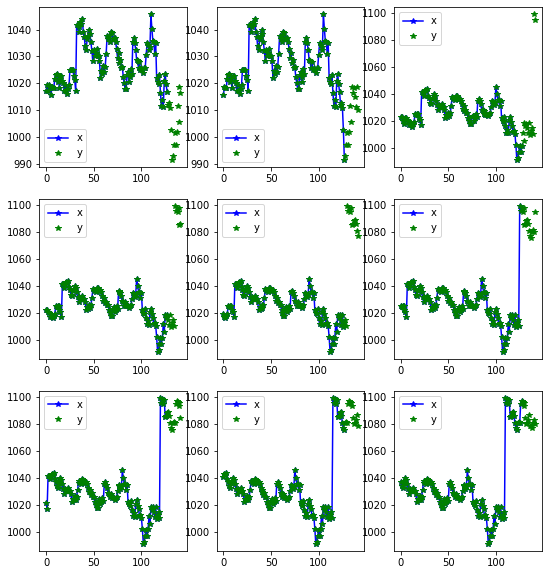

In [ ]:
horizon = 14
lookback = 56

items = ts_lists(df_train.iloc[:,1:].values)
splits = RandomSplitter()(items)

dl = TSDataLoader(items, horizon = 14, lookback = 128, step=5)
dl.show_batch()

In [ ]:
# hide
for o in dl:
    pass
for o in dl:
    pass

idx: 5608;y.std to high: 8703.7041015625 > 200
idx: 5609;y.std to high: 11640.787109375 > 200
idx: 6153;y.std to high: 760.0888061523438 > 200
idx: 5791;y.std to high: 93816.1484375 > 200
idx: 6154;y.std to high: 1063.582763671875 > 200
idx: 5792;y.std to high: 144455.5625 > 200
idx: 5555;y.std to high: 4270.94287109375 > 200
idx: 5793;y.std to high: 178156.6875 > 200
idx: 5556;y.std to high: 8144.22216796875 > 200
idx: 5557;y.std to high: 11118.1708984375 > 200
idx: 5555;y.std to high: 4270.94287109375 > 200
idx: 5556;y.std to high: 8144.22216796875 > 200
idx: 5557;y.std to high: 11118.1708984375 > 200
idx: 5791;y.std to high: 93816.1484375 > 200
idx: 5608;y.std to high: 8703.7041015625 > 200
idx: 5609;y.std to high: 11640.787109375 > 200
idx: 5792;y.std to high: 144455.5625 > 200
idx: 6153;y.std to high: 760.0888061523438 > 200
idx: 5793;y.std to high: 178156.6875 > 200
idx: 6154;y.std to high: 1063.582763671875 > 200


In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
